<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
:پروژه ی دوم
</font>
</h1>
<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
تحلیل برهم کنش دو جمعیت نورونی تحریکی و مهاری
</font>
</h1>
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4 color="orange">
  عرشیا ربیعی 
    
</font> 
</p>
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4 color="orange">
۶۱۰۳۹۸۱۲۵ 
    
</font> 
</p>

In [1]:
from pymonntorch import *
import torch
import matplotlib.pyplot as plt


In [2]:
settings = {'device' : 'cpu' , 'def_type' : torch.float32 }
settings = {'device' : 'cpu' , 'def_type' : torch.float32}
torch.manual_seed(73)
N = 50
EXC_N = int(0.8*N)
INH_N = int(0.2*N)
REGULAR_SPIKE = {'a' : 0.02 , 'b' : 0.2 , 'c' : -65 , 'd' : 8}
IB = {'a' : 0.02 , 'b' : 0.2 , 'c' : -55 , 'd' : 4}
CHATTERING = {'a' : 0.02 , 'b' : 0.2 , 'c' : -50 , 'd' : 2}
LOW_THRESHOLD_SPIKING = {'a' : 0.02 , 'b' : 0.25 , 'c' : -65 , 'd' : 2}
FAST_SPIKING = {'a' : 0.1 , 'b' : 0.2 , 'c' : -65 , 'd' : 2}
PARAMETER_CHOOSE_EXC = REGULAR_SPIKE
PARAMETER_CHOOSE_INH = FAST_SPIKING
INPUT_I = 0
NUM_OF_ITERATIONS = 300
STD = 3
COEF = 5

In [3]:
class Time(Behavior):
    def initialize(self,network):
        network.dt = self.parameter('dt' , 1)
        network.passed = 0
    def forward(self , network):
        network.passed += network.dt

In [4]:
class Dendrite(Behavior):
    def forward(self, n):
        for syn in n.afferent_synapses['GABA']:
            n.I -= syn.I
        for syn in n.afferent_synapses['GLUTAMATE']:
            n.I += syn.I

In [5]:
class InputSynapse(Behavior):
    def initialize(self,syn):
        self.density = self.parameter('den' , 1)
        self.W = syn.matrix('uniform' ,density = self.density)
        self.coef = self.parameter('coef' , None)
    def forward(self , syn):
        pre_spike = syn.src.spike
        syn.I = torch.sum(self.W.t()[pre_spike],axis = 0)* self.coef

In [6]:
class I_clip(Behavior):
    def forward(self , n):
        n.I = torch.clip(n.I , 0 , INPUT_I)

In [7]:
class Izhikevich(Behavior):
    def initialize(self , n):
        self.a = self.parameter('a' , None , required=True)
        self.b = self.parameter('b' , None , required=True)
        self.c = self.parameter('c' , None , required=True)
        self.d = self.parameter('d' , None , required=True)
        self.threshold = self.parameter('threshold' , 30)
        n.v = n.vector('uniform') * -70
        n.u = n.vector('uniform') * -15
        
        n.spike = n.v > self.threshold
        self.dt = 1
        n.I = torch.normal(INPUT_I , STD , size=(n.size ,))
        n.I_stable = torch.clone(n.I)
    def _fire(self , n):
        n.spike = n.v > self.threshold
        n.v[n.spike] = self.c
        n.u[n.spike] += self.d
    def _dv_du(self,n):
        self.dv = 0.04* (n.v**2) + 5*n.v + 140 - n.u + n.I
        self.du = self.a*(self.b * n.v - n.u)
    def forward(self , n):
        n.I = n.I_stable
        self._fire(n)
        self._dv_du(n)
        n.v += self.dv * n.network.dt
        n.u += self.du * n.network.dt


In [8]:
net = Network(settings=settings , behavior={
    1 : Time(dt = 1),
})

In [9]:
pop1 = NeuronGroup(net= net , size= int(0.8*N), tag= 'Excitatory' , behavior={
    3 : I_clip(),
    4 : Dendrite(),
    5 : Recorder(tag='exc_rec2' , variables = ['I']),
    6 : Izhikevich(**PARAMETER_CHOOSE_EXC),
    8 : Recorder(tag='exc_rec' , variables = ['v' , 'u']),
    9 : EventRecorder(tag='exc_spike' , variables=['spike'])
})

In [10]:
pop2 = NeuronGroup(net= net , size= int(0.2*N) , tag= 'Inhibitory' , behavior={
    3 : I_clip(),
    4 : Dendrite(),
    5 : Recorder(tag='inh_rec2' , variables = ['I']),
    6 : Izhikevich(**PARAMETER_CHOOSE_INH),
    8 : Recorder(tag='inh_rec' , variables = ['v' , 'u']),
    9 : EventRecorder(tag='inh_spike' , variables=['spike'])
})

In [11]:
synapse1 = SynapseGroup(net=net , tag = 'GABA', src= pop2 , dst= pop1 , behavior={
    2: InputSynapse(coef =COEF , den = 1)
})
synapse2 = SynapseGroup(net=net ,tag= 'GLUTAMATE' , src= pop1 , dst=pop2 , behavior={
    2:InputSynapse(coef = COEF , den = 1)
})
synapse3 = SynapseGroup(net=net ,tag= 'GLUTAMATE' , src= pop1 , dst=pop1 , behavior={
    2:InputSynapse(coef = COEF, den = 1)
})
synapse4 = SynapseGroup(net=net ,tag= 'GABA' , src= pop2 , dst=pop2 , behavior={
    2:InputSynapse(coef = COEF , den = 1)
})

In [12]:
net.initialize()
net.simulate_iterations(NUM_OF_ITERATIONS)

Network['Network'](Neurons: tensor(50)|2 groups, Synapses: tensor(2500)|4 groups){1:Time(dt=1,)}
NeuronGroup['Excitatory', 'NeuronGroup', 'ng'](40){3:I_clip()4:Dendrite()5:Recorder(tag=exc_rec2,variables=['I'],)6:Izhikevich(a=0.02,b=0.2,c=-65,d=8,)8:Recorder(tag=exc_rec,variables=['v', 'u'],)9:EventRecorder(tag=exc_spike,variables=['spike'],)}
NeuronGroup['Inhibitory', 'NeuronGroup', 'ng'](10){3:I_clip()4:Dendrite()5:Recorder(tag=inh_rec2,variables=['I'],)6:Izhikevich(a=0.1,b=0.2,c=-65,d=2,)8:Recorder(tag=inh_rec,variables=['v', 'u'],)9:EventRecorder(tag=inh_spike,variables=['spike'],)}
SynapseGroup['GABA', 'SynapseGroup', 'syn', 'Inhibitory => Excitatory'](D40xS10){2:InputSynapse(coef=5,den=1,),}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'Excitatory => Inhibitory'](D10xS40){2:InputSynapse(coef=5,den=1,),}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'Excitatory => Excitatory'](D40xS40){2:InputSynapse(coef=5,den=1,),}
SynapseGroup['GABA', 'SynapseGroup', 'syn', 'Inhibitory =

310.00328063964844

In [13]:
exc_activity = []
inh_activity = []
for i in range(1 , NUM_OF_ITERATIONS+1):
    exc_activity.append(torch.sum((net['exc_spike' ,0]['spike' , 0][: , 0] == i)) / EXC_N)
    inh_activity.append(torch.sum((net['inh_spike' ,0]['spike' , 0][: , 0] == i)) / INH_N)

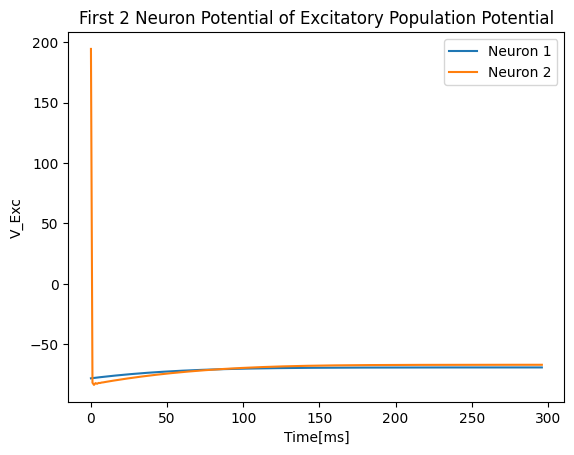

In [14]:
plt.plot(net['exc_rec' , 0].variables['v'][3:,:1], label = 'Neuron 1')
plt.plot(net['exc_rec' , 0].variables['v'][3:,1:2], label = 'Neuron 2')
plt.title('First 2 Neuron Potential of Excitatory Population Potential')
plt.xlabel('Time[ms]')
plt.ylabel('V_Exc')
plt.legend();

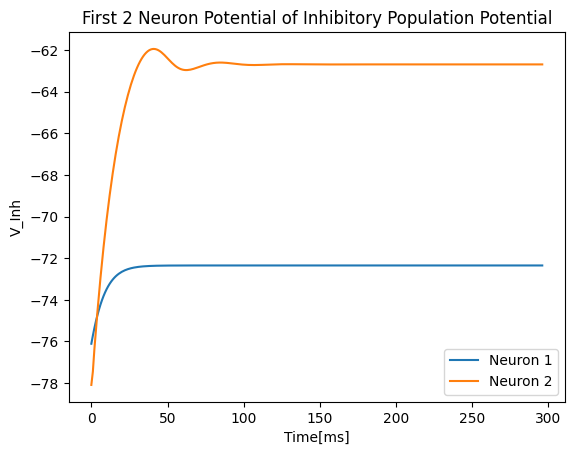

In [15]:
plt.plot(net['inh_rec' , 0].variables['v'][3:,:1] , label = 'Neuron 1')
plt.plot(net['inh_rec' , 0].variables['v'][3:,1:2] , label = 'Neuron 2')
plt.title('First 2 Neuron Potential of Inhibitory Population Potential')
plt.xlabel('Time[ms]')
plt.ylabel('V_Inh')
plt.legend();

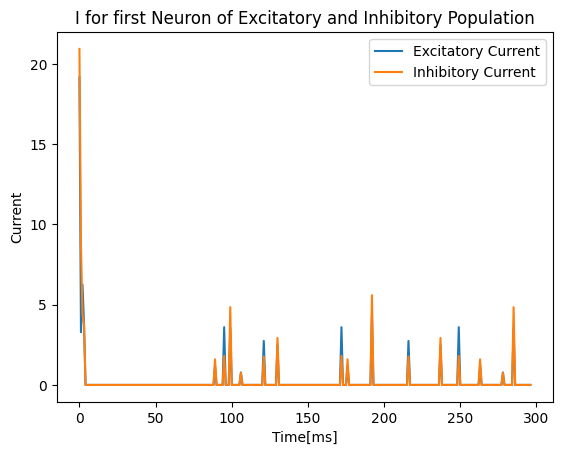

In [16]:
plt.plot(net['exc_rec2' , 0].variables['I'][3:,:1] , label = 'Excitatory Current')
plt.plot(net['inh_rec2' , 0].variables['I'][3:,:1] ,label = 'Inhibitory Current')
plt.title('I for first Neuron of Excitatory and Inhibitory Population')
plt.xlabel('Time[ms]')
plt.ylabel('Current')
plt.legend();

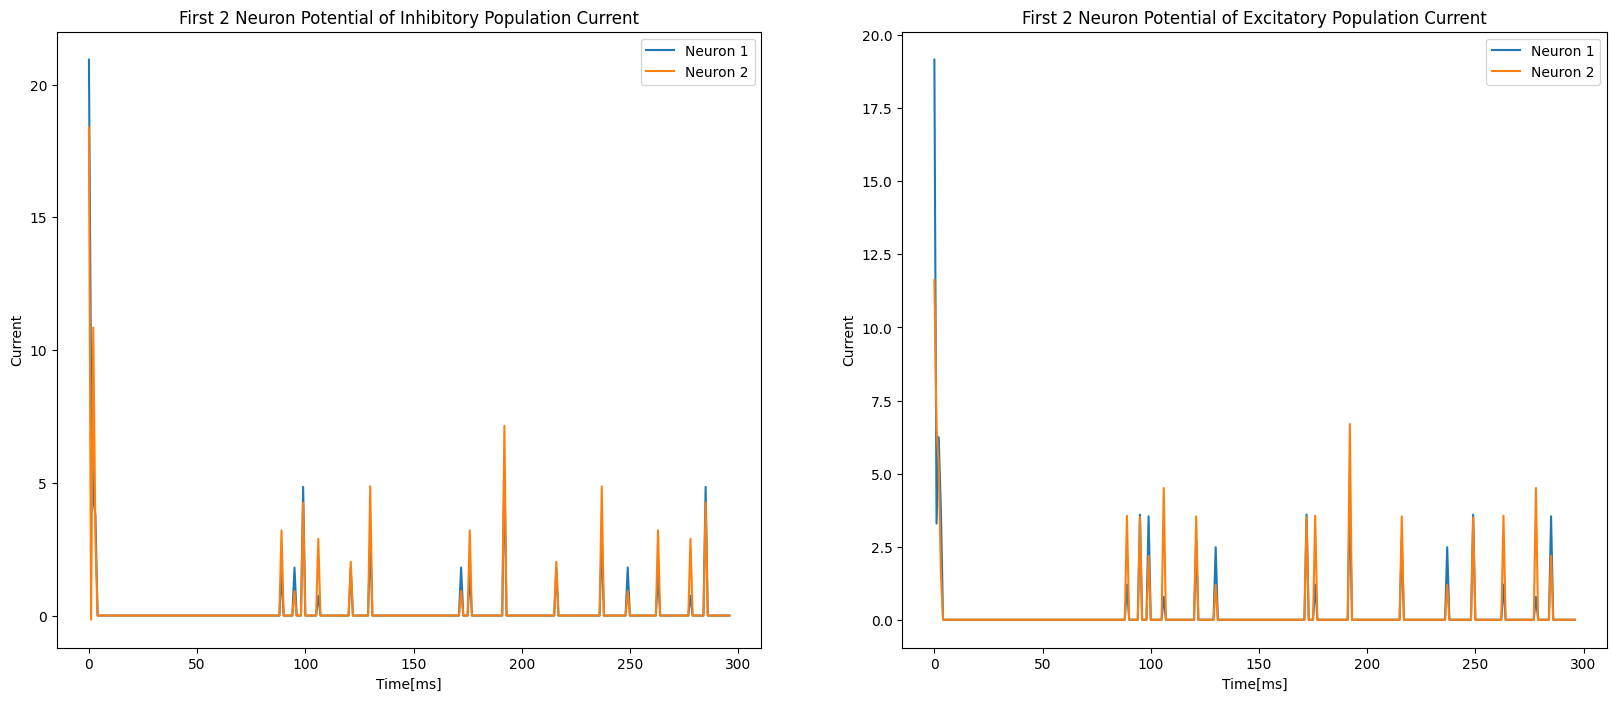

In [17]:
fig , ax = plt.subplots(1,2 , figsize = (20,8))
ax[0].plot(net['inh_rec2' , 0].variables['I'][3:,:1] , label = 'Neuron 1')
ax[0].plot(net['inh_rec2' , 0].variables['I'][3:,1:2] , label = 'Neuron 2')
ax[0].legend()
ax[1].plot(net['exc_rec2' , 0].variables['I'][3:,:1] , label = 'Neuron 1')
ax[1].plot(net['exc_rec2' , 0].variables['I'][3:,1:2] , label = 'Neuron 2')
ax[1].legend();
ax[0].set_title('First 2 Neuron Potential of Inhibitory Population Current')
ax[0].set_xlabel('Time[ms]')
ax[1].set_title('First 2 Neuron Potential of Excitatory Population Current')
ax[1].set_xlabel('Time[ms]')
ax[0].set_ylabel('Current')
ax[1].set_ylabel('Current');


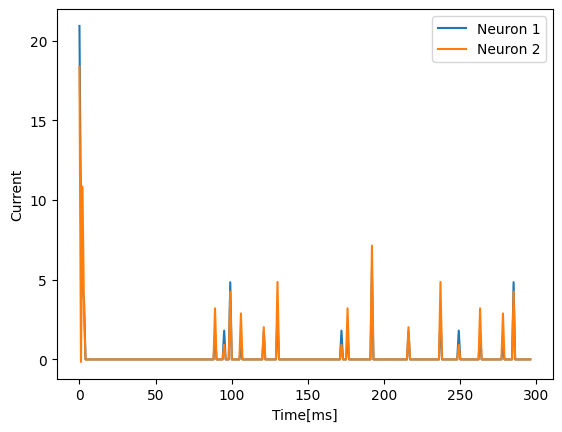

In [18]:
plt.plot(net['inh_rec2' , 0].variables['I'][3:,:1] , label = 'Neuron 1')
plt.plot(net['inh_rec2' , 0].variables['I'][3:,1:2] , label = 'Neuron 2')
plt.xlabel('Time[ms]')
plt.ylabel('Current')
plt.legend();

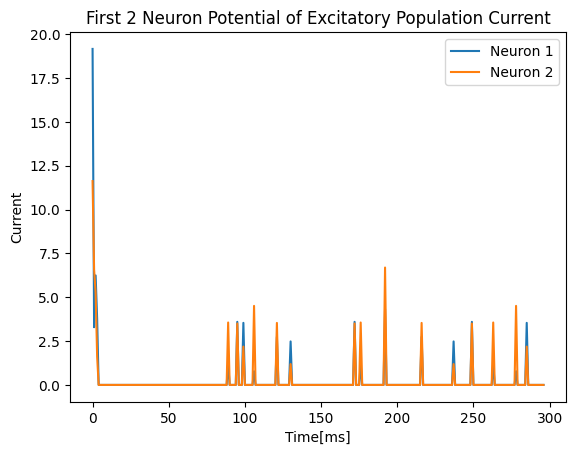

In [19]:
plt.plot(net['exc_rec2' , 0].variables['I'][3:,:1] , label = 'Neuron 1')
plt.plot(net['exc_rec2' , 0].variables['I'][3:,1:2] , label = 'Neuron 2')
plt.title('First 2 Neuron Potential of Excitatory Population Current')
plt.xlabel('Time[ms]')
plt.ylabel('Current')
plt.legend();

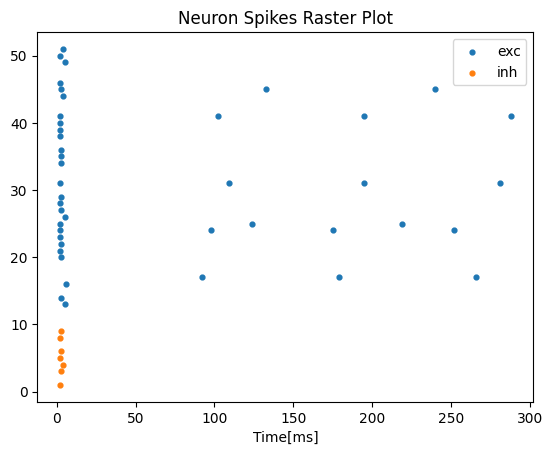

In [20]:
plt.scatter(net["exc_spike",0]["spike",0][:,0],net["exc_spike",0]["spike",0][:,1]+ 12, s = 12 , label = 'exc')
plt.scatter(net['inh_spike' , 0]['spike', 0][: , 0],net['inh_spike',0]['spike',0][: , 1] ,s = 12 , label = 'inh')
plt.title('Neuron Spikes Raster Plot')
plt.xlabel('Time[ms]')
plt.legend();

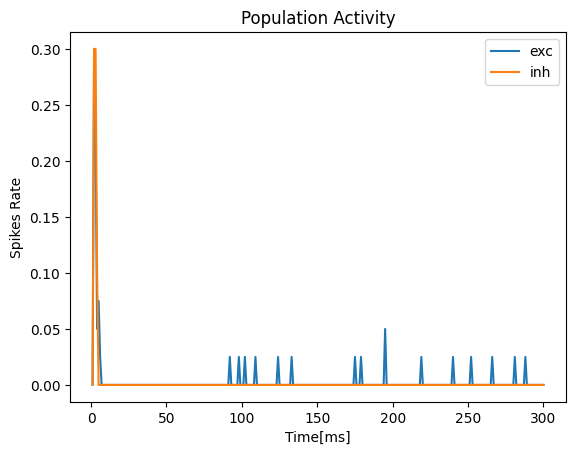

In [21]:
plt.plot([i for i in range(1,NUM_OF_ITERATIONS+1)] , exc_activity , label='exc')
plt.plot([i for i in range(1,NUM_OF_ITERATIONS+1)] , inh_activity, label='inh')
plt.xlabel('Time[ms]')
plt.ylabel('Spikes Rate')
plt.title('Population Activity')
plt.legend();